# Neural Style Transfer with Multi-Input Conditioning

This notebook implements:
- Neural style transfer using a CNN (VGG19)
- Threshold-based style blending
- Dataset preparation with content and style images
- Evaluation and visualization
- Bonus: Vision Transformer-based extension

In [1]:

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor
from torchvision.transforms.functional import to_pil_image
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

try:
    from transformers import ViTModel, ViTFeatureExtractor
except ImportError:
    print("Install 'transformers' to use ViT: pip install transformers")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 50


c:\Users\Mohamed Sakr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🛠 Utility Functions

In [2]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze().transpose(1, 2, 0)
    image = (image + 1) / 2  
    return np.clip(image, 0, 1)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)


## 📦 Dataset Class

In [3]:

class StyleTransferDataset(Dataset):
    def __init__(self, content_dir, style_dir, transform):
        self.content_images = [os.path.join(content_dir, img) for img in os.listdir(content_dir)]
        self.style_images = [os.path.join(style_dir, img) for img in os.listdir(style_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.content_images)

    def __getitem__(self, idx):
        content_image = Image.open(self.content_images[idx]).convert('RGB')
        style_image = Image.open(self.style_images[idx % len(self.style_images)]).convert('RGB')
        
        content_tensor = self.transform(content_image)
        style_tensor = self.transform(style_image)
        threshold = torch.tensor(random.uniform(0, 1)).view(1, 1, 1)
        return content_tensor, style_tensor, threshold

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


## 🧠 VGG Encoder

In [4]:

class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.enc_1 = nn.Sequential(*vgg[:2])
        self.enc_2 = nn.Sequential(*vgg[2:7])
        self.enc_3 = nn.Sequential(*vgg[7:12])
        self.enc_4 = nn.Sequential(*vgg[12:21])
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        h = self.enc_1(x)
        h1 = self.enc_2(h)
        h2 = self.enc_3(h1)
        h3 = self.enc_4(h2)
        return h1, h2, h3


## 🔄 Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        return self.decode(x)


## 🧩 Full Style Transfer Model

In [6]:

class StyleTransferNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VGGFeatures()
        self.decoder = Decoder()

    def forward(self, content, style, threshold):
        c_feat = self.encoder(content)[-1]
        s_feat = self.encoder(style)[-1]
        blended = threshold * s_feat + (1 - threshold) * c_feat
        return self.decoder(blended)


## 🏋️ Training Function

In [7]:
def train_model(model, dataloader, val_loader, epochs):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for i, (content, style, threshold) in enumerate(dataloader):
            content, style, threshold = content.to(DEVICE), style.to(DEVICE), threshold.to(DEVICE)
            output = model(content, style, threshold)

            out_feats = model.encoder(output)
            c_feats = model.encoder(content)
            s_feats = model.encoder(style)

            # Content loss from last layer
            loss_c = criterion(out_feats[-1], c_feats[-1])

            # Style loss from all layers
            loss_s = sum(
                criterion(gram_matrix(out_feats[j]), gram_matrix(s_feats[j]))
                for j in range(len(out_feats))
            )

            # Amplify style loss, modulated by threshold
            loss = loss_c + 250 * threshold.mean() * loss_s

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Save sample output image from first batch every 5 epochs
            if epoch % 5 == 0 and i == 0:
                with torch.no_grad():
                    img_array = im_convert(output[0])  
                    img = Image.fromarray((img_array * 255).astype(np.uint8))  
                    img.save(f"preview_epoch{epoch}.jpg")


        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")


## 🔍 Evaluation Function

In [8]:

def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, (content, style, threshold) in enumerate(test_loader):
            content, style, threshold = content.to(DEVICE), style.to(DEVICE), threshold.to(DEVICE)
            output = model(content, style, threshold)
            out_img = im_convert(output)
            plt.figure()
            plt.imshow(out_img)
            plt.title(f"Example {i+1}, Threshold={threshold.item():.2f}")
            plt.axis('off')
            if i == 9:
                break
        plt.show()


## 🎁 BONUS: Vision Transformer Module

In [9]:
class ViTFeatureBlender(nn.Module):
    """
    A neural module that uses a Vision Transformer (ViT) to extract features
    from content and style images, blends them using a style threshold,
    and returns the combined feature representation.
    """
    def __init__(self, model_name="google/vit-base-patch16-224", device="cpu"):
        super(ViTFeatureBlender, self).__init__()
        self.device = device

        # Load pretrained ViT and feature extractor
        self.extractor = ViTFeatureExtractor.from_pretrained(model_name)
        self.vit = ViTModel.from_pretrained(model_name)

        # Freeze ViT parameters to avoid fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = False

        self.vit.to(self.device)

    def preprocess(self, batch_tensor):
        """
        Converts a batch of image tensors to a list of PIL images,
        which are compatible with ViTFeatureExtractor.
        """
        pil_images = [to_pil_image(img.cpu().clamp(0, 1)) for img in batch_tensor]
        encoded = self.extractor(images=pil_images, return_tensors="pt").to(self.device)
        return encoded

    def forward(self, content_batch, style_batch, threshold):
        """
        Inputs:
            content_batch: torch.Tensor [B, C, H, W]
            style_batch:   torch.Tensor [B, C, H, W]
            threshold:     torch.Tensor or float scalar in [0, 1]
        Returns:
            blended_features: torch.Tensor of blended ViT features
        """
        # Preprocess inputs
        content_inputs = self.preprocess(content_batch)
        style_inputs = self.preprocess(style_batch)

        # Extract ViT features
        content_features = self.vit(**content_inputs).last_hidden_state  # [B, seq_len, hidden_dim]
        style_features = self.vit(**style_inputs).last_hidden_state

        # Compute blended features using threshold
        if isinstance(threshold, torch.Tensor):
            t = threshold.mean().item()
        else:
            t = float(threshold)

        blended_features = t * style_features + (1 - t) * content_features
        return blended_features

## ▶️ Run the Full Pipeline

c:\Users\Mohamed Sakr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mohamed Sakr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 19.5028
Epoch 2/50, Loss: 19.1371
Epoch 3/50, Loss: 18.1247
Epoch 4/50, Loss: 18.6396
Epoch 5/50, Loss: 17.6322
Epoch 6/50, Loss: 17.6452
Epoch 7/50, Loss: 17.1537
Epoch 8/50, Loss: 16.7032
Epoch 9/50, Loss: 17.5379
Epoch 10/50, Loss: 16.0247
Epoch 11/50, Loss: 15.5773
Epoch 12/50, Loss: 15.7441
Epoch 13/50, Loss: 15.2068
Epoch 14/50, Loss: 14.8723
Epoch 15/50, Loss: 14.9184
Epoch 16/50, Loss: 14.6489
Epoch 17/50, Loss: 15.0676
Epoch 18/50, Loss: 13.8625
Epoch 19/50, Loss: 13.2939
Epoch 20/50, Loss: 14.3673
Epoch 21/50, Loss: 13.5030
Epoch 22/50, Loss: 13.3729
Epoch 23/50, Loss: 13.0198
Epoch 24/50, Loss: 13.6552
Epoch 25/50, Loss: 12.5357
Epoch 26/50, Loss: 13.4181
Epoch 27/50, Loss: 12.6589
Epoch 28/50, Loss: 12.9438
Epoch 29/50, Loss: 12.3325
Epoch 30/50, Loss: 12.1015
Epoch 31/50, Loss: 11.7947
Epoch 32/50, Loss: 12.8445
Epoch 33/50, Loss: 10.9778
Epoch 34/50, Loss: 11.1863
Epoch 35/50, Loss: 10.8285
Epoch 36/50, Loss: 10.5188
Epoch 37/50, Loss: 11.4397
Epoch 38/5

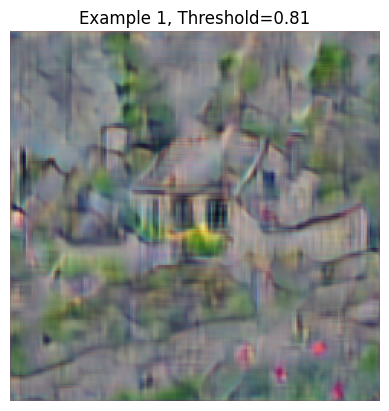

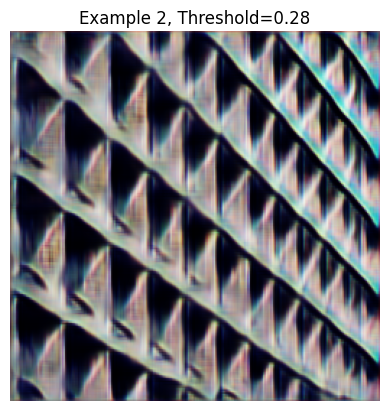

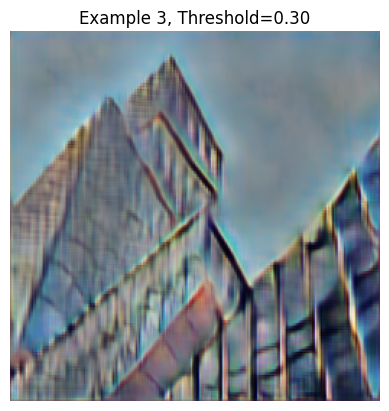

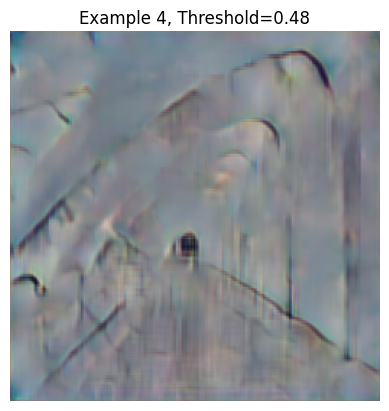

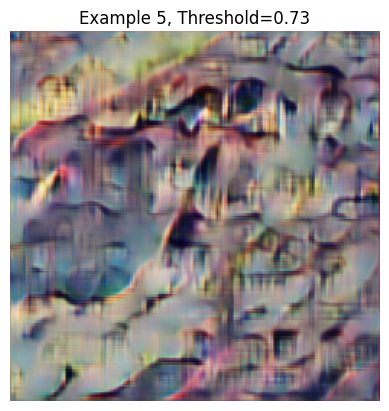

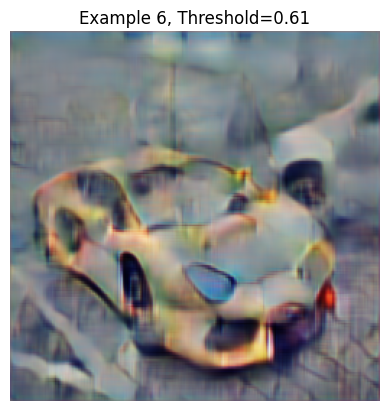

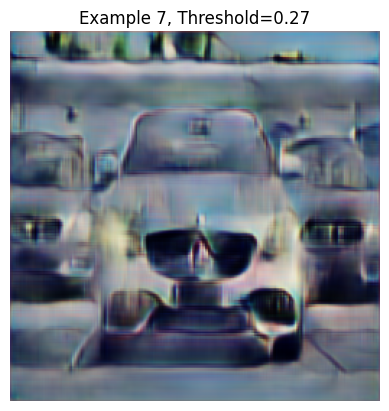

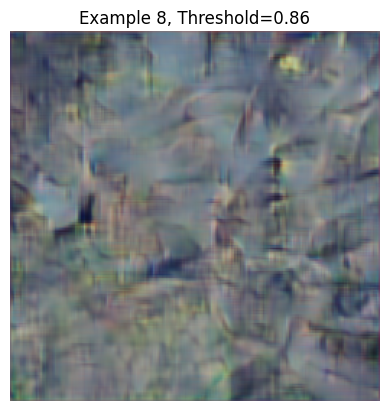

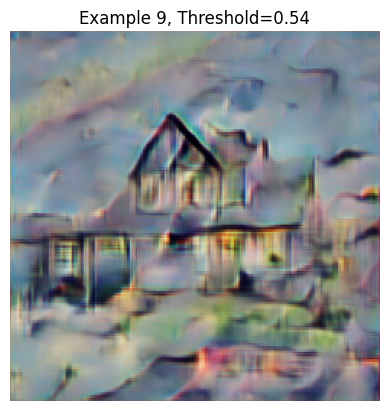

In [10]:

if __name__ == "__main__":
    dataset = StyleTransferDataset("data/content", "data/style", transform)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=1)

    model = StyleTransferNet().to(DEVICE)
    train_model(model, train_loader, val_loader, EPOCHS)
    torch.save(model.state_dict(), "style_transfer_model.pth")
    evaluate_model(model, test_loader)


## web App

In [11]:
import gradio as gr
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 256

model = StyleTransferNet().to(DEVICE)
model.load_state_dict(torch.load("style_transfer_model.pth", map_location=DEVICE))  
model.eval()

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze().transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    return Image.fromarray((image.clip(0, 1) * 255).astype("uint8"))


def stylize(content_img, style_img, threshold):
    content_tensor = transform(content_img).unsqueeze(0).to(DEVICE)
    style_tensor = transform(style_img).unsqueeze(0).to(DEVICE)
    threshold_tensor = torch.tensor(threshold).view(1, 1, 1, 1).to(DEVICE)

    with torch.no_grad():
        output = model(content_tensor, style_tensor, threshold_tensor)
    
    return im_convert(output.squeeze(0))

gr.Interface(
    fn=stylize,
    inputs=[
        gr.Image(type="pil", label="Content Image"),
        gr.Image(type="pil", label="Style Image"),
        gr.Slider(0, 1, value=0.5, label="Style Threshold")
    ],
    outputs=gr.Image(type="pil", label="Stylized Output"),
    title="Neural Style Transfer Web App",
    description="Upload a content and style image, set the threshold, and generate a stylized image using a trained neural model."
).launch()


c:\Users\Mohamed Sakr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mohamed Sakr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
